# Part A: Priors for variational autoencoders (VAEs)

##  Show a plot of the prior and the aggregate posterior.

## Discuss and compare across priors the match between the priors and the aggregate posteriors.


## Evaluate the test set log-likelihood as approximated by the ELBO.

## Discuss and compare the test set log-likelihood across priors.

# A standard Gaussian prior

In [ ]:
# Arg parse not working, until I get it to work this would be the code:

In [6]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np

In [3]:
print('hej')

import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm

class GaussianPrior(nn.Module):
    def __init__(self, M):
        super(GaussianPrior, self).__init__()
        self.M = M
        self.mean = nn.Parameter(torch.zeros(self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.M), requires_grad=False)

    def forward(self):
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)

class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)

class BernoulliDecoder(nn.Module):
    def __init__(self, decoder_net):
        super(BernoulliDecoder, self).__init__()
        self.decoder_net = decoder_net
        self.std = nn.Parameter(torch.ones(28, 28)*0.5, requires_grad=True)

    def forward(self, z):
        logits = self.decoder_net(z)
        return td.Independent(td.Bernoulli(logits=logits), 2)

class VAE(nn.Module):
    def __init__(self, prior, decoder, encoder):
        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        q = self.encoder(x)
        z = q.rsample()
        elbo = torch.mean(self.decoder(z).log_prob(x) - td.kl_divergence(q, self.prior()), dim=0)
        return elbo

    def sample(self, n_samples=1):
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()
    
    def forward(self, x):
        return -self.elbo(x)

def train(model, optimizer, data_loader, epochs, device):
    model.train()

    total_steps = len(data_loader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):
        data_iter = iter(data_loader)
        for x in data_iter:
            x = x[0].to(device)
            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=loss.item(), epoch=f"{epoch+1}/{epochs}")
            progress_bar.update()

if __name__ == "__main__":
    from torchvision import datasets, transforms
    from torchvision.utils import save_image, make_grid
    import glob

    # Load MNIST as binarized at 'thresshold' and create data loaders
    thresshold = 0.5
    mnist_train_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=True, download=True,
                                                                    transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])),
                                                    batch_size=32, shuffle=True)
    mnist_test_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=False, download=True,
                                                                transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])),
                                                    batch_size=32, shuffle=True)

    # Define prior distribution
    M = 32
    prior = GaussianPrior(M)

    # Define encoder and decoder networks
    encoder_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, M*2),
    )

    decoder_net = nn.Sequential(
        nn.Linear(M, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Unflatten(-1, (28, 28))
    )

    # Define VAE model
    decoder = BernoulliDecoder(decoder_net)
    encoder = GaussianEncoder(encoder_net)
    model = VAE(prior, decoder, encoder).to('cpu')

    # Train model
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train(model, optimizer, mnist_train_loader, epochs=10, device='cpu')

    # Save model
    torch.save(model.state_dict(), 'model.pt')

    # Generate samples
    model.eval()
    with torch.no_grad():
        samples = (model.sample(64)).cpu() 
        save_image(samples.view(64, 1, 28, 28), 'samples.png')


hej


100%|██████████| 9912422/9912422 [00:00<00:00, 17050280.65it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65942130.55it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 15240559.12it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12785589.78it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Training: 100%|██████████| 18750/18750 [02:42<00:00, 115.34it/s, epoch=10/10, loss=77.3]


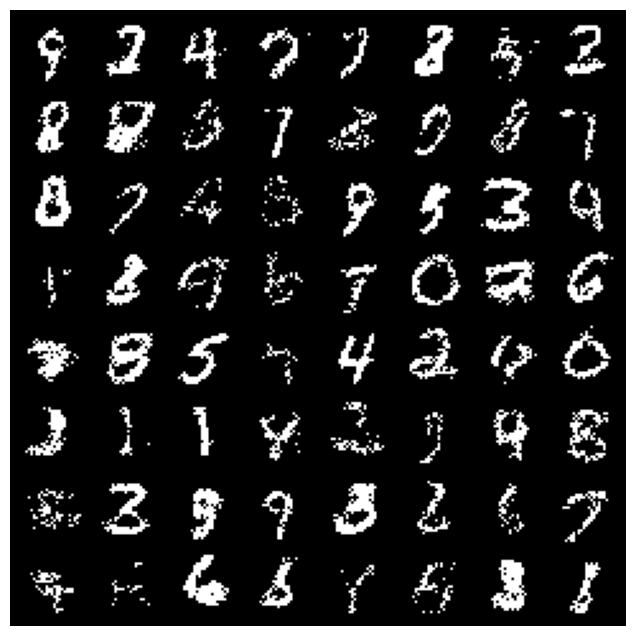

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Loading the generated samples: 
samples_image = Image.open('samples.png')

# Display the samples
plt.figure(figsize=(8, 8))
plt.imshow(samples_image)
plt.axis('off')
plt.show()

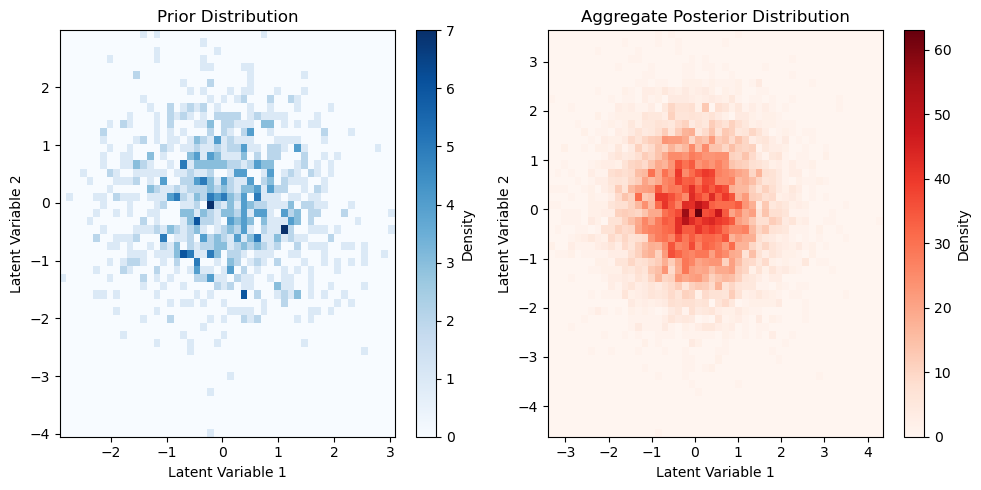

In [7]:
# Generate samples from the prior
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_samples = 1000
prior_samples = prior().sample(torch.Size([n_samples])).detach().cpu().numpy()

# Generate samples from the aggregate posterior
posterior_samples = []
with torch.no_grad():
    for x, _ in mnist_test_loader:
        x = x.to(device)
        q = model.encoder(x)
        z = q.sample()
        posterior_samples.append(z.cpu().numpy())
posterior_samples = np.concatenate(posterior_samples, axis=0)

# Plot prior and aggregate posterior
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Prior Distribution')
plt.hist2d(prior_samples[:, 0], prior_samples[:, 1], bins=50, cmap='Blues')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar(label='Density')

plt.subplot(1, 2, 2)
plt.title('Aggregate Posterior Distribution')
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=50, cmap='Reds')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.colorbar(label='Density')

plt.tight_layout()
plt.show()